In [6]:
from cdp_data import CDPInstances, datasets

# pull Long Beach data in Oct to Nov 2022
long_beach_oct_nov_2022 = datasets.get_session_dataset(
    CDPInstances.LongBeach,  # specify the city (or county) council we want data from
    start_datetime="2022-10-01",  # YYYY-MM-DD format
    end_datetime="2022-11-01",  # YYYY-MM-DD format
    store_transcript=True,  # store transcripts locally for fast file reading
    store_transcript_as_csv=True,
)

Fetching each model attached to event_ref:   0%|          | 0/8 [00:00<?, ?it/s]

Fetching transcripts:   0%|          | 0/8 [00:00<?, ?it/s]

Converting and storing each transcript as a CSV: 8it [00:09,  1.23s/it]


In [3]:
import pandas as pd
import spacy
import numpy as np
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from flair.data import Sentence
from flair.models import SequenceTagger

In [12]:
# try with the 2nd meeting
example_session = long_beach_oct_nov_2022.iloc[1]
example_session

session_datetime                                  2022-10-07 00:00:00+00:00
session_index                                                             0
session_content_hash      7a4115eaf950df5993f3e64bf792320bfcb9b21e9770a7...
video_uri                 https://storage.googleapis.com/download/storag...
video_start_time                                                       None
video_end_time                                                         None
caption_uri                                                            None
external_source_id                                                     None
id                                                             fe855a4e00b6
key                                                    session/fe855a4e00b6
event                     <cdp_backend.database.models.Event object at 0...
transcript                <cdp_backend.database.models.Transcript object...
transcript_path           /Users/angelzhou/Desktop/CDP_research/sig-cdp/...
transcript_a

In [13]:
import pandas as pd

example_transcript_df = pd.read_csv(example_session.transcript_as_csv_path)
example_transcript_df

,index,confidence,start_time,end_time,text,speaker_index,speaker_name,annotations
0,0,0.816301,362.2,363.5,Go ahead and get it started.,NaN,NaN,NaN
1,1,0.869943,365.5,367.0,"Good evening, everyone.",NaN,NaN,NaN
2,2,0.869943,367.3,371.5,I'd like to go ahead and call this session of ...,NaN,NaN,NaN
3,3,0.869943,372.0,373.0,Can I get a roll call?,NaN,NaN,NaN
4,4,0.869943,373.0,379.8,"Please commence your templin here, commissione...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1979,1979,0.912839,12198.8,12199.2,Yeah.,NaN,NaN,NaN
1980,1980,0.912839,12200.6,12200.9,Okay.,NaN,NaN,NaN
1981,1981,0.912839,12205.8,12206.7,Okay.,NaN,NaN,NaN
1982,1982,0.718904,12210.4,12210.8,Luscious.,NaN,NaN,NaN


In [14]:
example_transcript_df["text"]

0                            Go ahead and get it started.
1                                 Good evening, everyone.
2       I'd like to go ahead and call this session of ...
3                                  Can I get a roll call?
4       Please commence your templin here, commissione...
                              ...                        
1979                                                Yeah.
1980                                                Okay.
1981                                                Okay.
1982                                            Luscious.
1983     These are find a reason to use my, I even fou...
Name: text, Length: 1984, dtype: object

## Construct a df with spacy, transformers, and flair

In [55]:
# pip install -U spacy
# python -m spacy download en_core_web_sm
import spacy
import numpy as np

# Load spacy English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

# transformer
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
nlp_t = pipeline("ner", model=model, tokenizer=tokenizer)

# flair
tagger = SequenceTagger.load('ner')

temp_rows = []
for t in range(len(long_beach_oct_nov_2022)):
    example_session = long_beach_oct_nov_2022.iloc[t]
    sentences = pd.read_csv(example_session.transcript_as_csv_path)
    # Process sentences in the text column
    for i in range(len(sentences)):
        # spacy
        doc = nlp(sentences["text"][i])
        for entity in doc.ents:
            temp_rows.append([example_session["id"], "spacy", sentences.index[i], entity.label_, entity.text])

        # transformer
        ner_results = nlp_t(sentences["text"][i])
        for entity in ner_results:
            temp_rows.append([example_session["id"], "transformers", sentences.index[i], entity["entity"], entity["word"]])

        # flair
        # make a sentence
        sentence = Sentence(sentences["text"][i])
        # run NER over sentence
        tagger.predict(sentence)
        for entity in sentence.get_spans('ner'):
            temp_rows.append([example_session["id"], "flair", sentences.index[i], entity.get_label("ner").value, entity.text])


res_df = pd.DataFrame(temp_rows, columns=["session_id", "ner_model", "sentence_index", "named_entity_type", "entity"])
res_df

/opt/anaconda3/envs/sig-cdp/lib/python3.9/site-packages/huggingface_hub/file_download.py:594: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2023-01-20 21:52:22,098 loading file /Users/angelzhou/.flair/models/ner-english/4f4cdab26f24cb98b732b389e6cebc646c36f54cfd6e0b7d3b90b25656e4262f.8baa8ae8795f4df80b28e7f7b61d788ecbb057d1dc85aacb316f1bd02837a4a4
2023-01-20 21:52:24,769 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


,session_id,ner_model,sentence_index,named_entity_type,entity
0,d0e9c5cd2bdf,spacy,1,ORG,Commission
1,d0e9c5cd2bdf,spacy,1,TIME,60 4 p.m.
2,d0e9c5cd2bdf,transformers,1,B-ORG,equity
3,d0e9c5cd2bdf,transformers,1,I-ORG,relations
4,d0e9c5cd2bdf,transformers,1,I-ORG,Commission
...,...,...,...,...,...
14295,7eaa181ea8e6,transformers,2369,I-ORG,Studios
14296,7eaa181ea8e6,transformers,2369,B-ORG,ABC
14297,7eaa181ea8e6,flair,2369,ORG,Sundar Studios
14298,7eaa181ea8e6,flair,2369,ORG,ABC


In [56]:
# save res_df to csv file
res_df.to_csv("NER_Angel.csv")

In [57]:
# pip install seaborn
# import seaborn as sns
spacy_df = res_df[res_df["ner_model"] == "spacy"]
spacy_df

,session_id,ner_model,sentence_index,named_entity_type,entity
0,d0e9c5cd2bdf,spacy,1,ORG,Commission
1,d0e9c5cd2bdf,spacy,1,TIME,60 4 p.m.
6,d0e9c5cd2bdf,spacy,2,CARDINAL,three
7,d0e9c5cd2bdf,spacy,2,DATE,today
8,d0e9c5cd2bdf,spacy,2,ORG,Camacho
...,...,...,...,...,...
14279,7eaa181ea8e6,spacy,2366,PRODUCT,Lagoon
14287,7eaa181ea8e6,spacy,2367,LOC,Marina
14291,7eaa181ea8e6,spacy,2369,PERSON,Sundar Studios
14292,7eaa181ea8e6,spacy,2369,ORG,ABC


In [58]:
transformers_df = res_df[res_df["ner_model"] == "transformers"]
transformers_df

,session_id,ner_model,sentence_index,named_entity_type,entity
2,d0e9c5cd2bdf,transformers,1,B-ORG,equity
3,d0e9c5cd2bdf,transformers,1,I-ORG,relations
4,d0e9c5cd2bdf,transformers,1,I-ORG,Commission
13,d0e9c5cd2bdf,transformers,2,B-PER,Cam
14,d0e9c5cd2bdf,transformers,2,I-PER,##ach
...,...,...,...,...,...
14289,7eaa181ea8e6,transformers,2367,I-LOC,green
14293,7eaa181ea8e6,transformers,2369,B-ORG,Sun
14294,7eaa181ea8e6,transformers,2369,I-ORG,##dar
14295,7eaa181ea8e6,transformers,2369,I-ORG,Studios


In [59]:
flair_df = res_df[res_df["ner_model"] == "flair"]
flair_df

,session_id,ner_model,sentence_index,named_entity_type,entity
5,d0e9c5cd2bdf,flair,1,ORG,Commission
22,d0e9c5cd2bdf,flair,2,PER,Camacho
23,d0e9c5cd2bdf,flair,2,PER,Camacho
24,d0e9c5cd2bdf,flair,2,PER,Nicholson
25,d0e9c5cd2bdf,flair,2,PER,Eric Center
...,...,...,...,...,...
14285,7eaa181ea8e6,flair,2366,MISC,Third and Pine
14286,7eaa181ea8e6,flair,2366,LOC,Lagoon
14290,7eaa181ea8e6,flair,2367,LOC,Marina
14297,7eaa181ea8e6,flair,2369,ORG,Sundar Studios


In [75]:
flair_df[(flair_df["session_id"] == "7eaa181ea8e6") & (flair_df["sentence_index"] == 2369)]

,session_id,ner_model,sentence_index,named_entity_type,entity
14297,7eaa181ea8e6,flair,2369,ORG,Sundar Studios
14298,7eaa181ea8e6,flair,2369,ORG,ABC


In [96]:
example_session = long_beach_oct_nov_2022.iloc[7]
example_transcript_df = pd.read_csv(example_session.transcript_as_csv_path)
example_transcript_df.iloc[2365:2371].text

2365                                            Festival.
2366    Which starts at 12, noon to 10 p.m. will be a ...
2367    And all of the floats will be at Marina green ...
2368                   See so, really excited about that.
2369    And really excited that the parade will be bro...
2370                 So can't wait to see you guys there.
Name: text, dtype: object

## Question 1:
### What types of entities are recognized over all the meetings? I.e. How many are people? How many are organizations? 

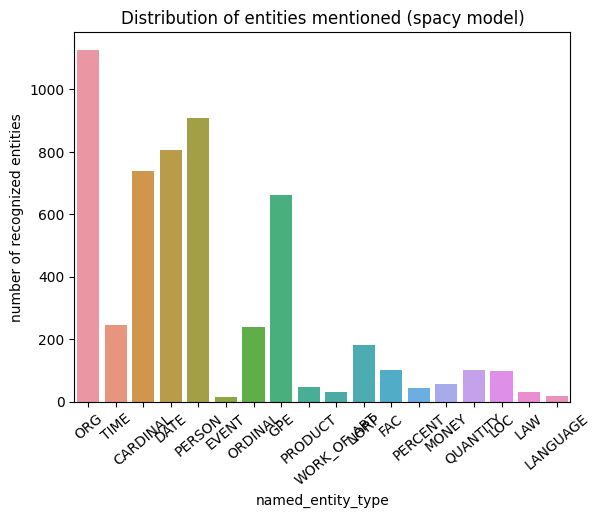

In [111]:
ax = sns.countplot(data=spacy_df, x="named_entity_type")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
_ = ax.set_ylabel("number of recognized entities")
_ = ax.set_title("Distribution of entities mentioned (spacy model)")

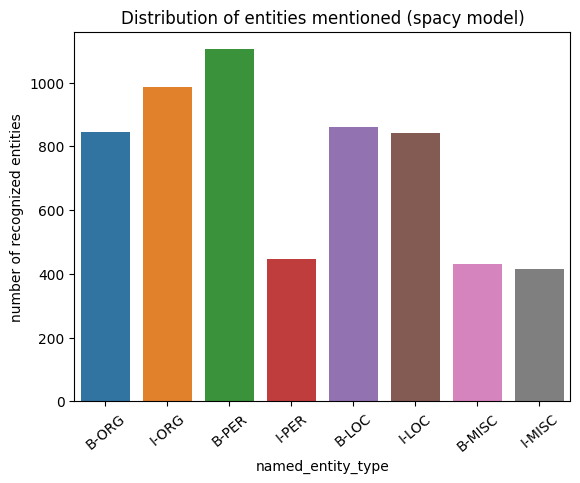

In [112]:
ax = sns.countplot(data=transformers_df, x="named_entity_type")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
_ = ax.set_ylabel("number of recognized entities")
_ = ax.set_title("Distribution of entities mentioned (spacy model)")

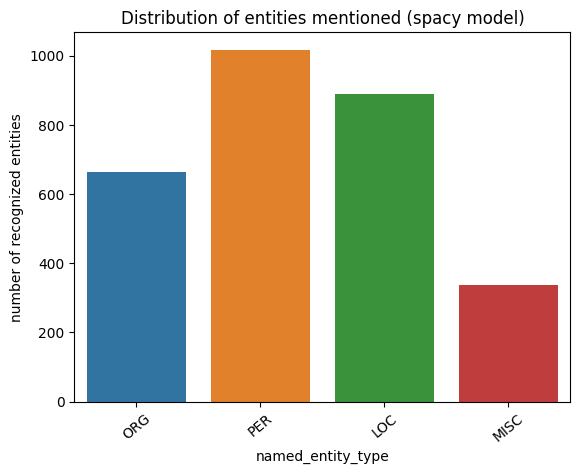

In [113]:
ax = sns.countplot(data=flair_df, x="named_entity_type")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
_ = ax.set_ylabel("number of recognized entities")
_ = ax.set_title("Distribution of entities mentioned (spacy model)")

## Question 2:
### What meetings have more or less entities recognized overall? We want to see the distribution of entities mentioned over different meetings. I.e. Meeting abcd1234 had 204 recognized entities, meeting efgh5678 had 559 recognized entities, etc.

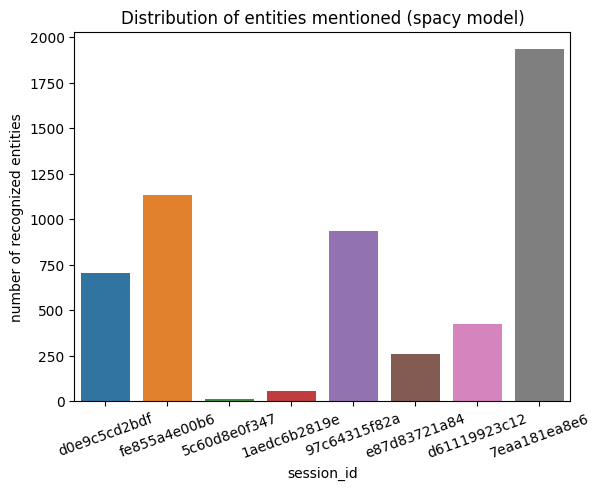

In [ ]:
ax = sns.countplot(data=spacy_df, x="session_id")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
_ = ax.set_ylabel("number of recognized entities")
_ = ax.set_title("Count of entities mentioned (spacy model)")

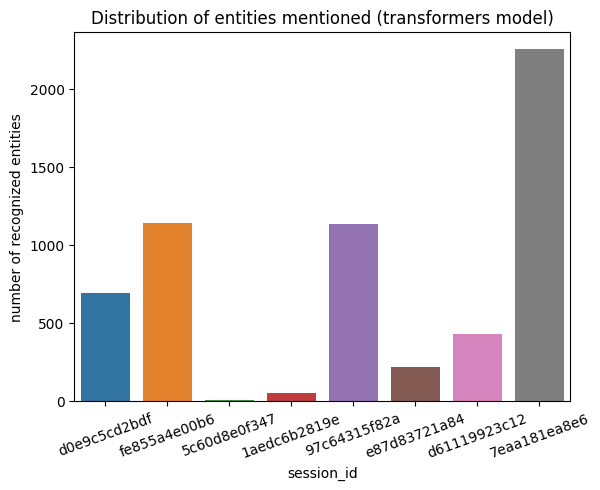

In [ ]:
ax = sns.countplot(data=transformers_df, x="session_id")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
_ = ax.set_ylabel("number of recognized entities")
_ = ax.set_title("Count of entities mentioned (transformers model)")

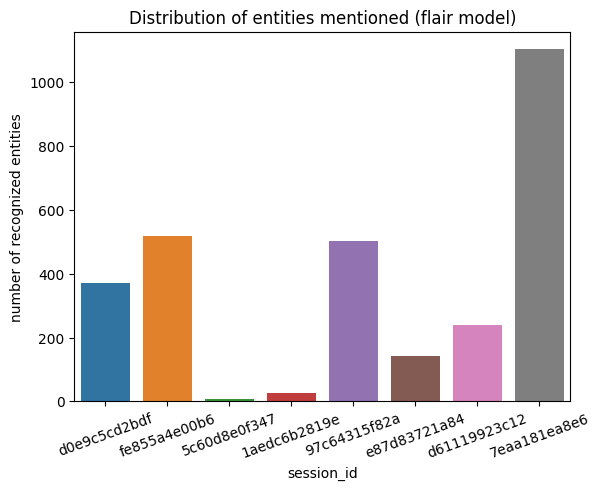

In [ ]:
ax = sns.countplot(data=flair_df, x="session_id")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
_ = ax.set_ylabel("number of recognized entities")
_ = ax.set_title("Count of entities mentioned (flair model)")

## Question 3:
### How are the NER model recognizing entities differently for each session?

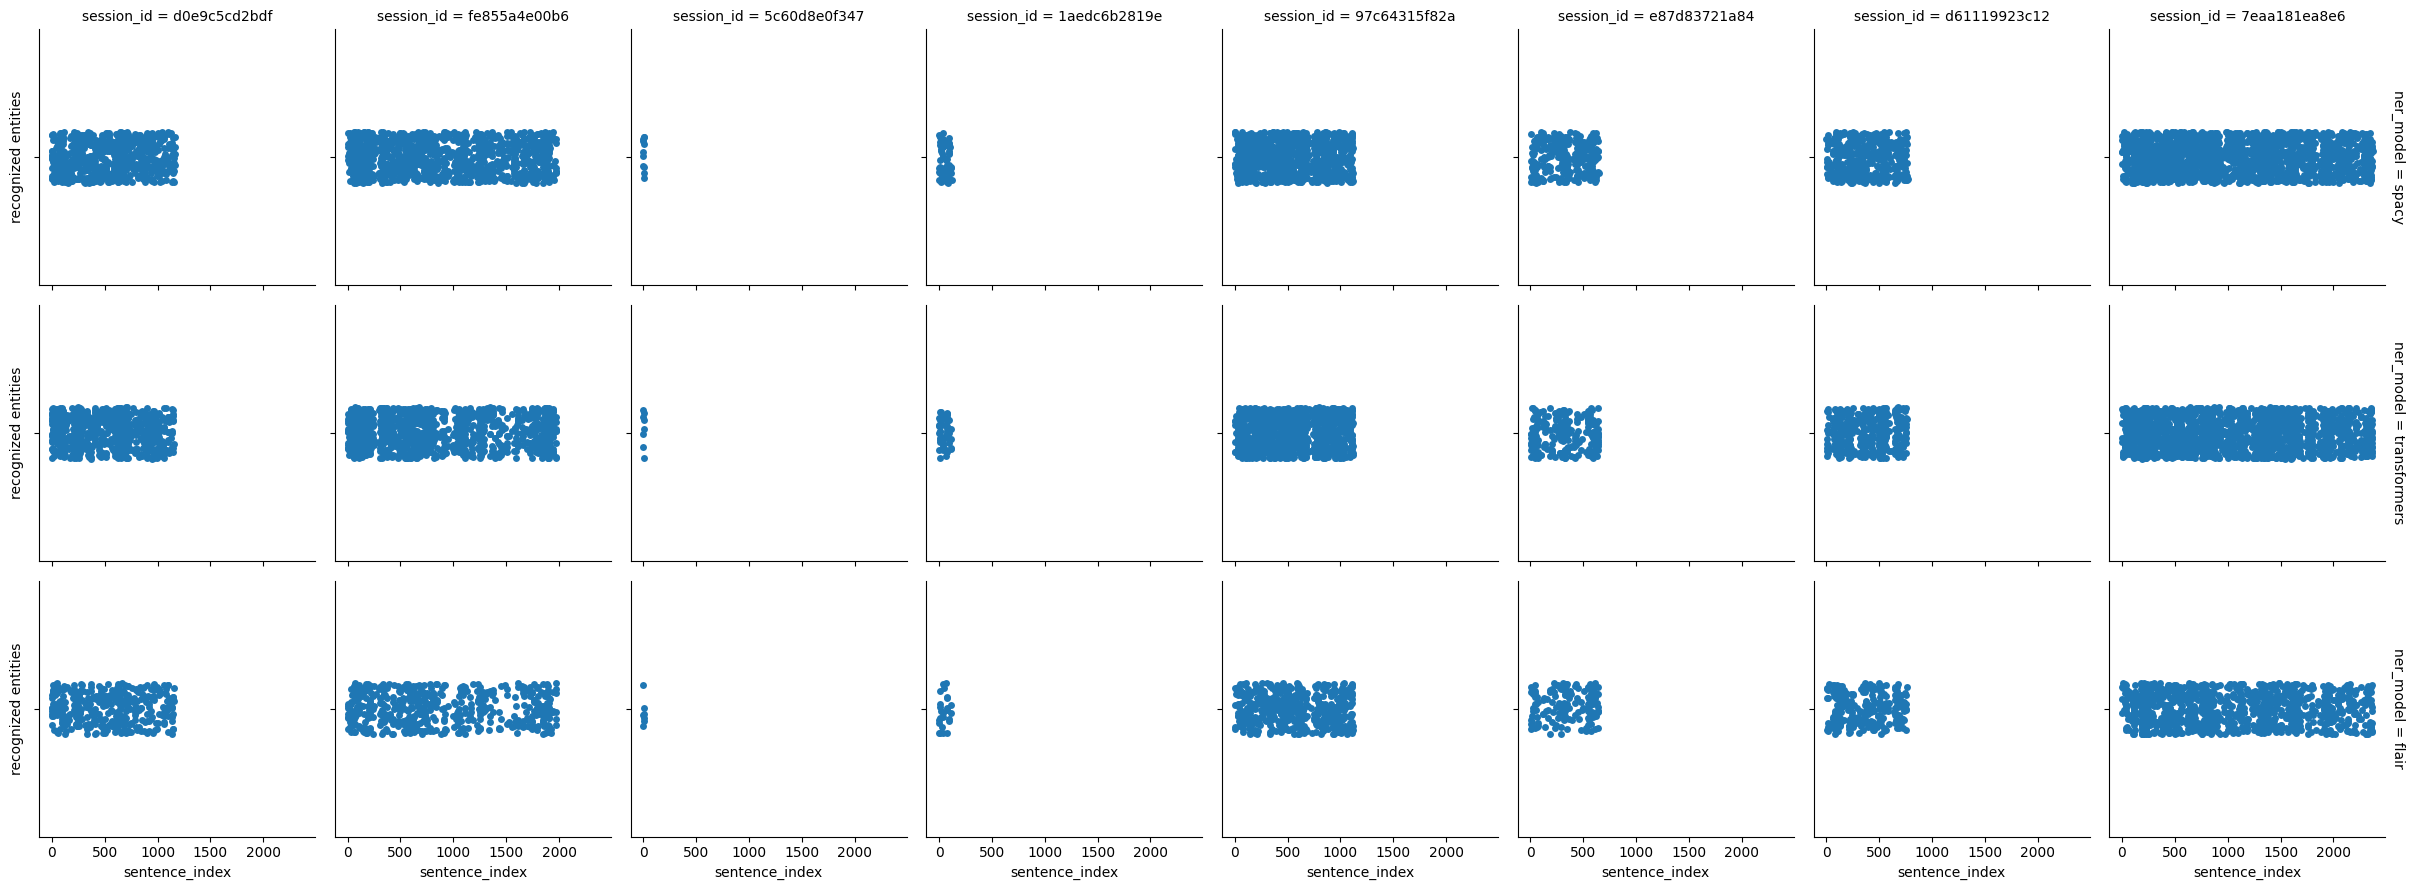

In [125]:
g = sns.FacetGrid(res_df, row="ner_model", col="session_id", margin_titles=True)
g.map_dataframe(sns.stripplot, x="sentence_index")
_ = g.set_axis_labels("sentence_index", "recognized entities")